In [ ]:
!pip install torchsummary
!pip install torchattacks
!pip install foolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.9/155.9 KB 3.5 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchsummary import summary
from PIL import Image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from copy import deepcopy

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

cuda


# Loading the dataset

In [ ]:
C, H, W = [3, 32, 32]
num_classes = 10

tfms = transforms.Compose(
    [
        transforms.Resize([H, W]),
        transforms.ToTensor(),
    ]
)
train_dataset = datasets.CIFAR10(root='datasets', train=True, transform=tfms, target_transform=None, download=True)
test_dataset = datasets.CIFAR10(root='datasets', train=False, transform=tfms, target_transform=None, download=True)

idx_to_class = { value:key for key, value in train_dataset.class_to_idx.items() } # for getting the class name from class indices when needed
class_to_idx = { key:value for key, value in train_dataset.class_to_idx.items() } # for getting the class indices from class names when needed

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar-10-python.tar.gz to datasets
Files already downloaded and verified


## Preliminary Visualization
The images in the dataset are 32 x 32 and have 3 channels for each color. Overall, there are a total of 3072 features per image considering every color value of every channel as a feature. \
This seems like a very large number, however, a neural network should be able to handle inputs of this size with decent speed using the given resources.

Number of samples in train_dataset: 50000
Number of samples in test_dataset : 10000
Number of classes: 10
Dimensions of input images: (32, 32, 3)


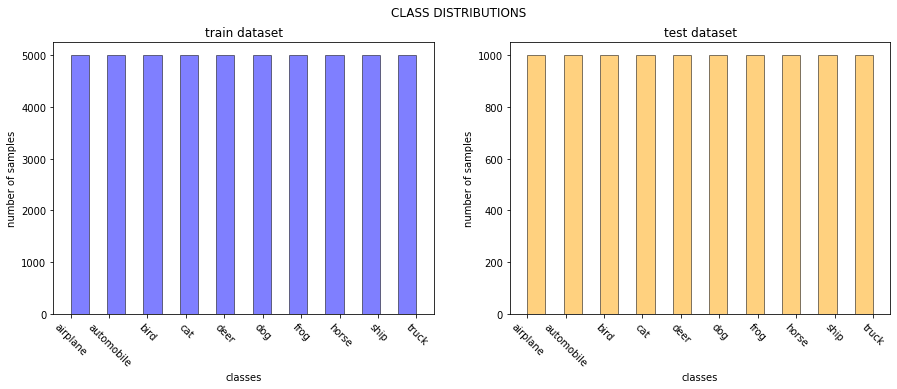

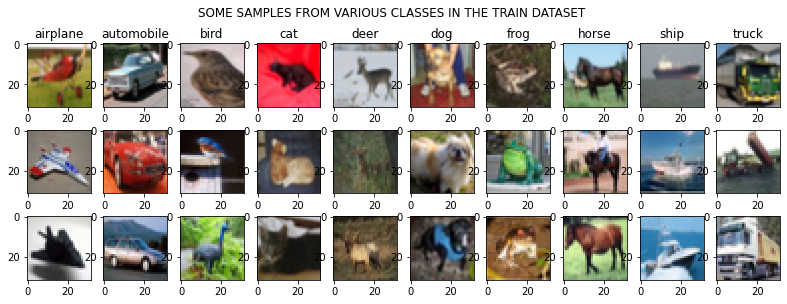

In [ ]:
print(f'Number of samples in train_dataset: {len(train_dataset)}')
print(f'Number of samples in test_dataset : {len(test_dataset) }')
print(f'Number of classes: {num_classes}')
print(f'Dimensions of input images: {H, W, C}')


# visualize the class distribution
def class_distribution(axs, pos, title, dset, color):
  axs[pos].hist(dset.targets, bins=num_classes+9, edgecolor='black', color=color, alpha=0.5)
  axs[pos].set_xticks([i for i in range(num_classes)])
  axs[pos].set_xticklabels([idx_to_class[i] for i in range(num_classes)], rotation=-45)
  axs[pos].set_xlabel('classes')
  axs[pos].set_ylabel('number of samples')
  axs[pos].set_title(title)


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[15, 5])
class_distribution(axs, 0, 'train dataset', train_dataset, 'blue')
class_distribution(axs, 1, 'test dataset' , test_dataset , 'orange')
fig.suptitle("Class distributions".upper())
plt.show()
print(), print()


# display some sample images from the dataset for each class from train dataset
max_display_count = 3
fig, axs = plt.subplots(nrows=max_display_count, ncols=10, figsize=[9*1.5, 1.5*max_display_count])
for class_idx in range(num_classes):
  count = max_display_count
  axs[0][class_idx].set_title(idx_to_class[class_idx])
  for image_idx in range(len(train_dataset)):
    image, label = train_dataset[image_idx]
    if label != class_idx: 
      continue
    elif count == 0:
      break
    count -= 1
    axs[count][class_idx].imshow(transforms.ToPILImage()(image))
fig.suptitle("some samples from various classes in the train dataset".upper())
plt.show()
del max_display_count, image, label, class_idx, count, image_idx

# Helper functions

In [ ]:
def get_accuracy(model, loader, count=-1):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader):
            if count == 0: break
            else: count -=1
            images, labels = images.to(device), labels.to(device)
            preds = model(images).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += (labels == labels).sum().item()
    model.train()
    return float(correct / total)

def get_loss(model, loader, criterion, count=-1):
    model.eval()
    losses, sizes = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader):
            if count == 0: break
            else: count -=1
            images, labels = images.to(device), labels.to(device)
            scores = model(images)
            loss = criterion(scores, labels)
            losses.append(loss.item())
            sizes.append(labels.size(0))
    model.train()
    losses, sizes = np.array(losses), np.array(sizes)
    return float(sum(losses * sizes) / sum(sizes))

def show_stats(losses, train_losses, test_losses, train_accuracies, test_accuracies, epoch):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[12, 4])
    axs[0].plot(losses)
    axs[0].set_title('losses, batch-wise')
    axs[1].plot(train_losses, label='train')
    axs[1].plot(test_losses, label='test')
    axs[1].set_title('losses, epoch-wise')
    axs[2].plot(train_accuracies, label='train')
    axs[2].plot(test_accuracies, label='test')
    axs[2].set_title('accuracies, epoch-wise')
    axs[2].legend()
    axs[1].legend()
    fig.suptitle(f'end of epoch#{epoch+1}, train accuracy:{train_accuracies[-1]*100:.3f}, test_accuracy:{test_accuracies[-1]*100:.3f}')
    plt.show()

In [ ]:
def bn_define(model):
    for m in model.modules():
        for child in model.children():
            if isinstance(child, nn.BatchNorm2d):
                child.track_running_stats = True
                child.running_mean = torch.zeros_like(child.running_mean)
                child.running_var = torch.ones_like(child.running_var)

def bn_compute(model, loader, count=-1):
    bn_define(model)
    model.train()
    for images, labels in tqdm(loader):
        if count == 0: break
        else: count -= 1
        images, labels = images.to(device), labels.to(device)
        model(images)

# Model class - CNN Classifier

In [ ]:


class CNN(nn.Module):
    def __init__(self, num_classes, input_channels):
        super(CNN, self).__init__()
        conv_layers = [64, 128, 256]
        self.layers = nn.ModuleList([
            nn.Conv2d(input_channels, conv_layers[0], kernel_size=3, padding=1, stride=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(conv_layers[0], conv_layers[1], kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(conv_layers[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(conv_layers[1], conv_layers[2], kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(conv_layers[2]),
            nn.ReLU(),
            nn.Flatten(),
        ])
        self.fc = nn.ModuleList([
            nn.Linear(8 * 8 * 256, 1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes, bias=False),
            nn.BatchNorm1d(num_classes),
        ])
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        for layer in self.fc:
            x = layer(x)
        return x

cnn_kwargs = {
    'num_classes': num_classes,
    'input_channels': C,
}
model = CNN(**cnn_kwargs).to(device)
summary(model, (C, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,728
       BatchNorm2d-5          [-1, 128, 16, 16]             256
              ReLU-6          [-1, 128, 16, 16]               0
         MaxPool2d-7            [-1, 128, 8, 8]               0
            Conv2d-8            [-1, 256, 8, 8]         294,912
       BatchNorm2d-9            [-1, 256, 8, 8]             512
             ReLU-10            [-1, 256, 8, 8]               0
          Flatten-11                [-1, 16384]               0
           Linear-12                 [-1, 1024]      16,777,216
      BatchNorm1d-13                 [-1, 1024]           2,048
             ReLU-14                 [-

# Part 1 - FGSM attack on basic CNN

## Training - CNN Classifier

### With AutoAugment

In [ ]:
model = CNN(**cnn_kwargs).to(device)

In [ ]:
num_epochs = 20
batch_size = 32
learning_rate = 3e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# AutoAugment: AutoAugment is a technique where a search algorithm is used to find the best combination of augmentation policies 
# for a given dataset and model architecture. In the paper "AutoAugment: Learning Augmentation Policies from Data" by Cubuk et al. (2019), 
# AutoAugment was shown to significantly improve performance on CIFAR-10 with small CNNs.
autoaugment = transforms.AutoAugment(policy=torchvision.transforms.autoaugment.AutoAugmentPolicy.CIFAR10)
float_to_uint8 = transforms.Lambda(lambda img_float: (img_float * 255).clamp(0, 255).to(torch.uint8))
uint8_to_float = transforms.Lambda(lambda img_uint8: img_uint8.to(torch.float32) / 255)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [ ]:
losses = []
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
state_dicts = []

100%|██████████| 313/313 [00:02<00:00, 147.12it/s]


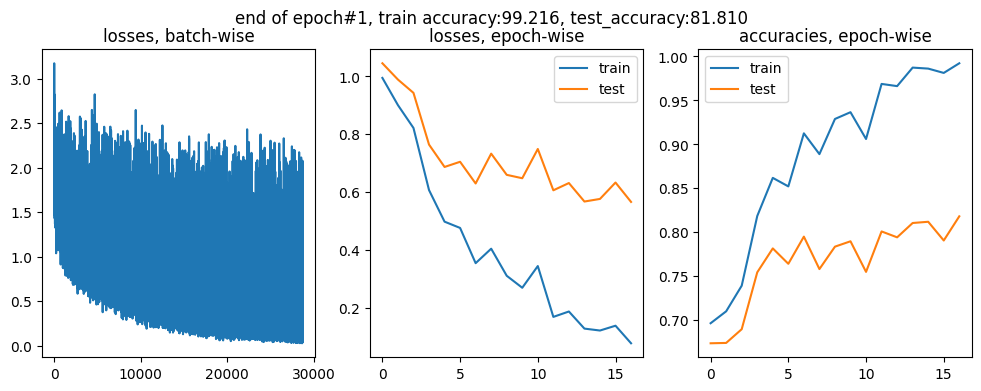

100%|██████████| 313/313 [00:02<00:00, 147.19it/s]


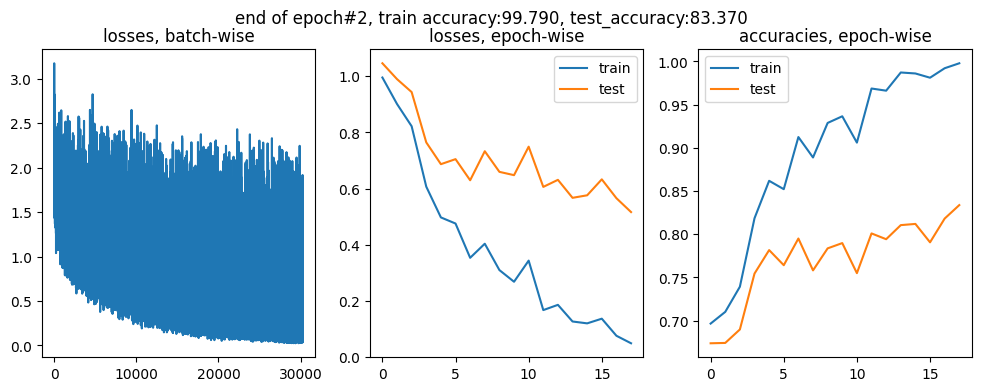

100%|██████████| 313/313 [00:02<00:00, 144.18it/s]


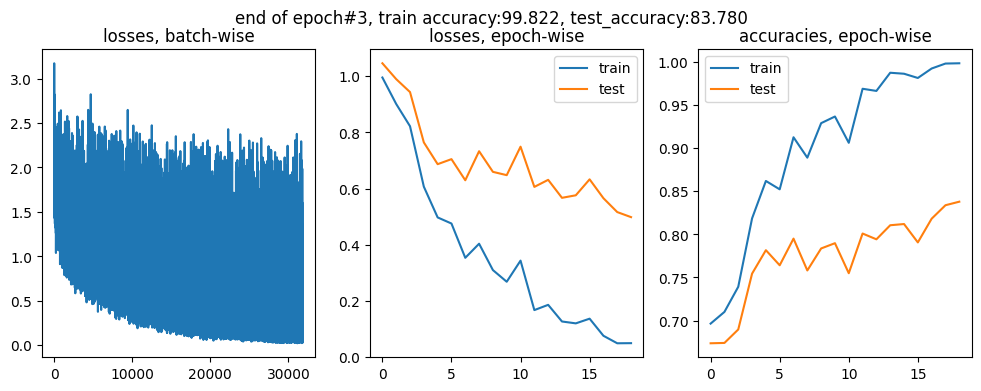

100%|██████████| 313/313 [00:02<00:00, 146.91it/s]


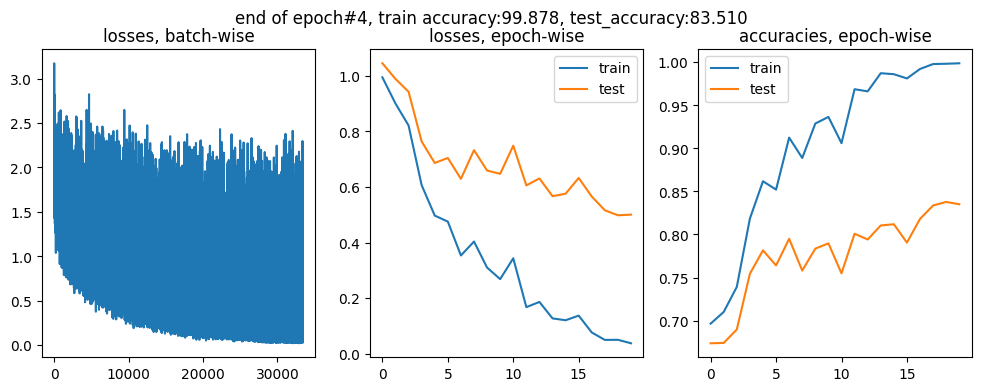

In [ ]:
model.to(device)
model.train()

# train_losses.append(get_loss(model, train_loader, criterion))
# test_losses.append(get_loss(model, test_loader, criterion))
# train_accuracies.append(get_accuracy(model, train_loader))
# test_accuracies.append(get_accuracy(model, test_loader))
for epoch in range(num_epochs):

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        images = uint8_to_float(autoaugment(float_to_uint8(images)))
        optimizer.zero_grad()
        scores = model(images)
        loss = criterion(scores, labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    train_losses.append(get_loss(model, train_loader, criterion))
    test_losses.append(get_loss(model, test_loader, criterion))
    train_accuracies.append(get_accuracy(model, train_loader))
    test_accuracies.append(get_accuracy(model, test_loader))
    show_stats(losses, train_losses, test_losses, train_accuracies, test_accuracies, epoch)
    state_dicts.append(deepcopy(model.state_dict()))


In [ ]:
for epoch, test_accuracy, state_dict in list(zip(range(len(state_dicts)), test_accuracies, state_dicts)):
    MODEL_SAVE_PATH = f'saved/cnn_autoaugment/epoch{epoch+1}_acc{test_accuracy}.pt'
    torch.save(state_dict, MODEL_SAVE_PATH)

### without AutoAugment

In [ ]:
model = CNN(**cnn_kwargs).to(device)

In [ ]:
num_epochs = 20
batch_size = 32
learning_rate = 3e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# AutoAugment: AutoAugment is a technique where a search algorithm is used to find the best combination of augmentation policies 
# for a given dataset and model architecture. In the paper "AutoAugment: Learning Augmentation Policies from Data" by Cubuk et al. (2019), 
# AutoAugment was shown to significantly improve performance on CIFAR-10 with small CNNs.
autoaugment = transforms.AutoAugment(policy=torchvision.transforms.autoaugment.AutoAugmentPolicy.CIFAR10)
float_to_uint8 = transforms.Lambda(lambda img_float: (img_float * 255).clamp(0, 255).to(torch.uint8))
uint8_to_float = transforms.Lambda(lambda img_uint8: img_uint8.to(torch.float32) / 255)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [ ]:
losses = []
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
state_dicts = []

100%|██████████| 313/313 [00:02<00:00, 141.47it/s]


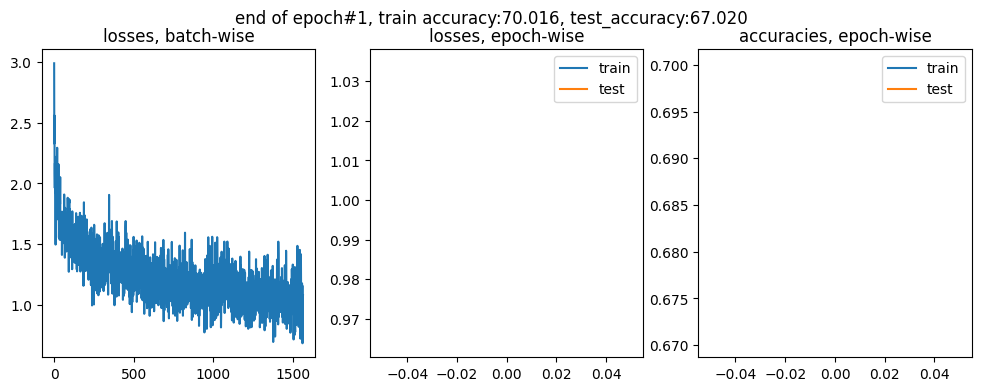

100%|██████████| 313/313 [00:02<00:00, 147.91it/s]


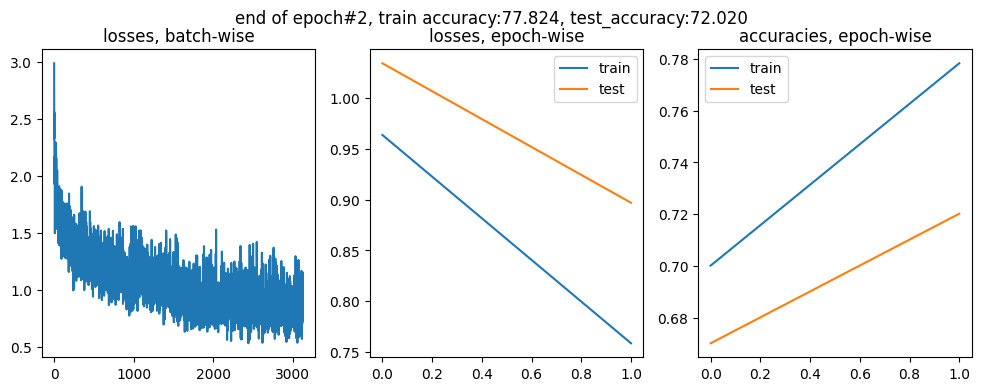

100%|██████████| 313/313 [00:02<00:00, 148.04it/s]


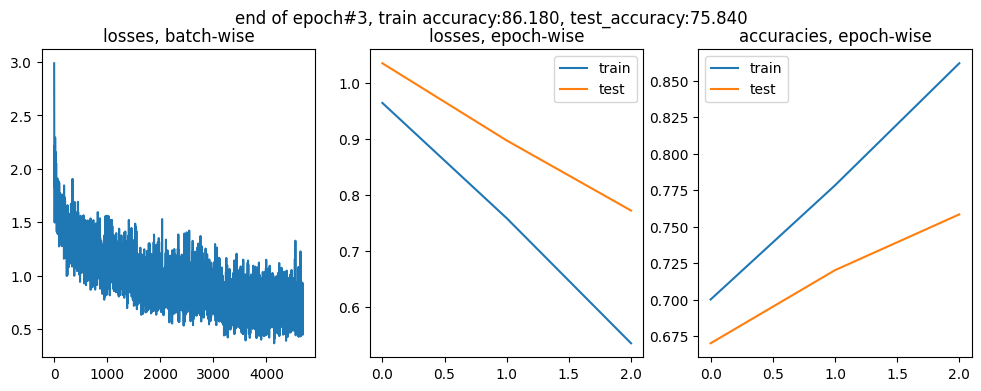

100%|██████████| 313/313 [00:02<00:00, 148.57it/s]


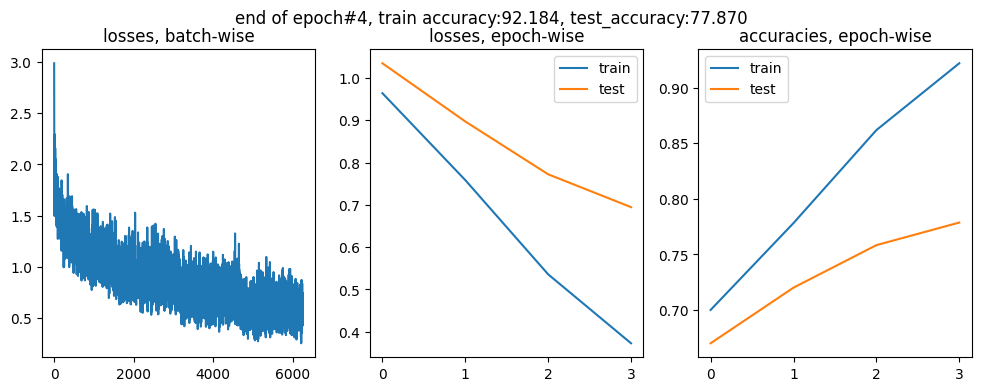

100%|██████████| 313/313 [00:02<00:00, 147.46it/s]


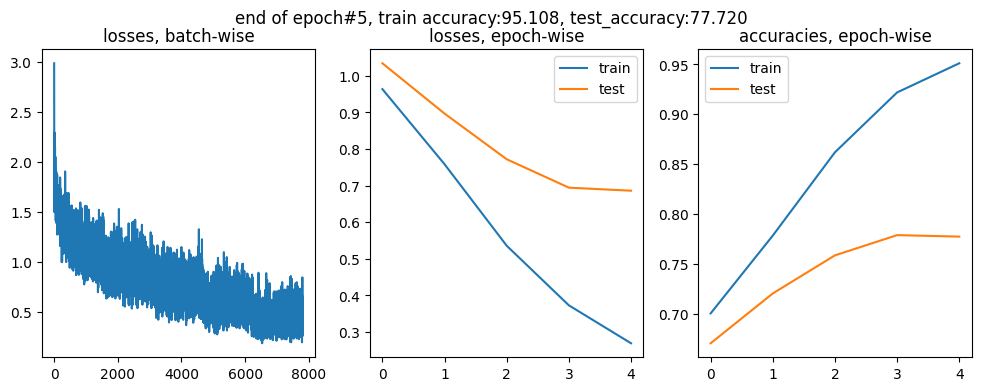

100%|██████████| 313/313 [00:02<00:00, 145.77it/s]


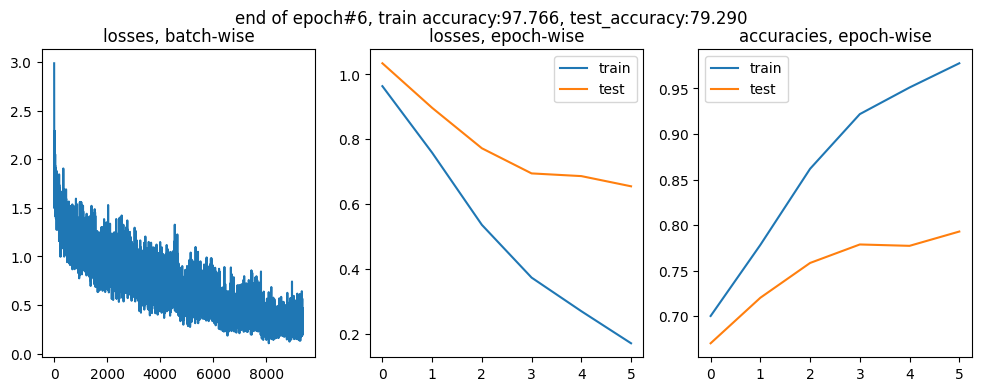

100%|██████████| 313/313 [00:02<00:00, 149.15it/s]


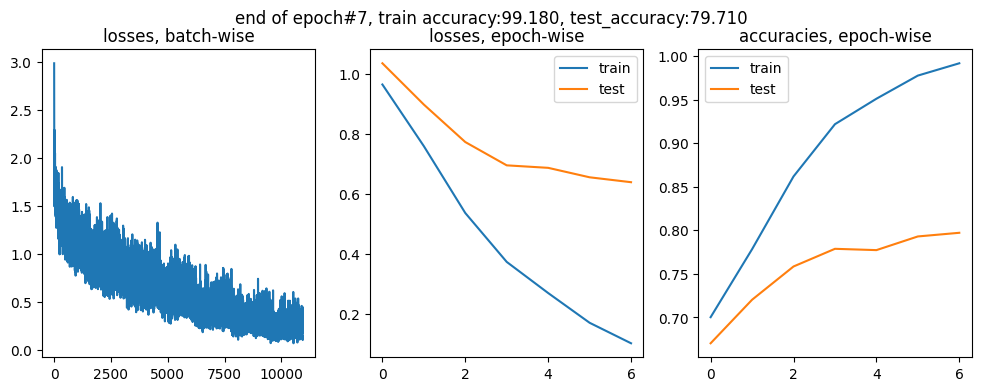

100%|██████████| 313/313 [00:02<00:00, 143.46it/s]


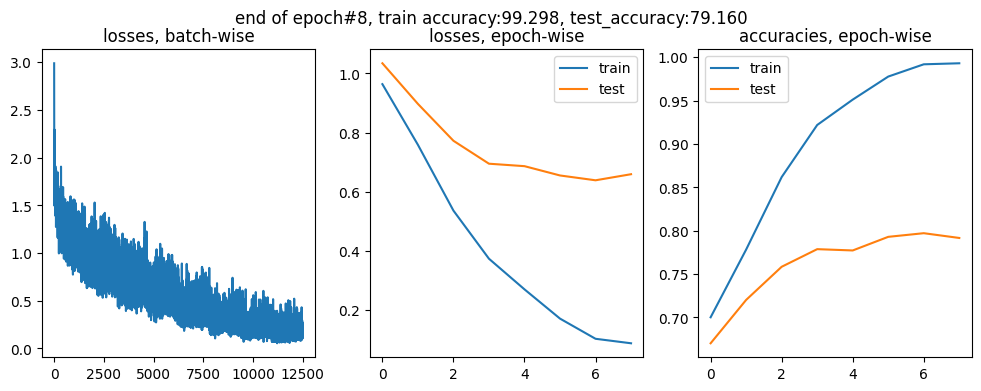

100%|██████████| 313/313 [00:02<00:00, 143.86it/s]


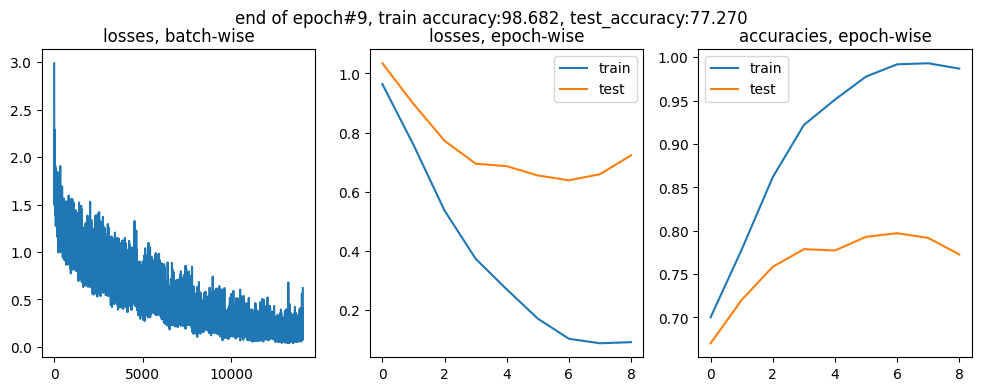

100%|██████████| 313/313 [00:02<00:00, 146.68it/s]


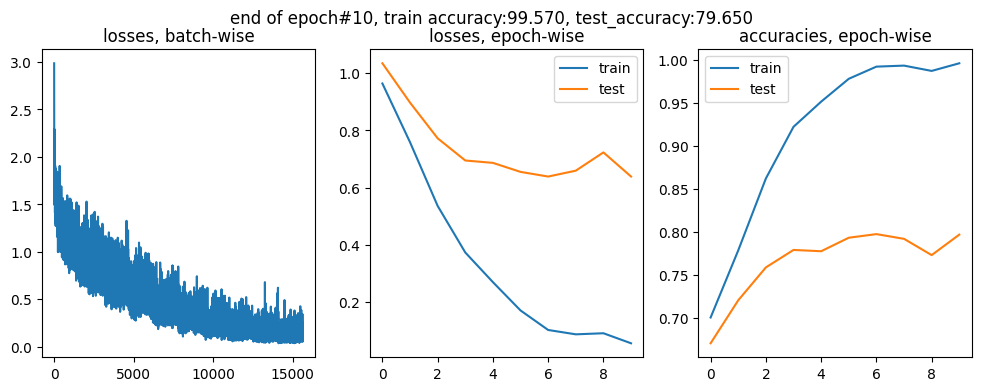

100%|██████████| 313/313 [00:02<00:00, 146.83it/s]


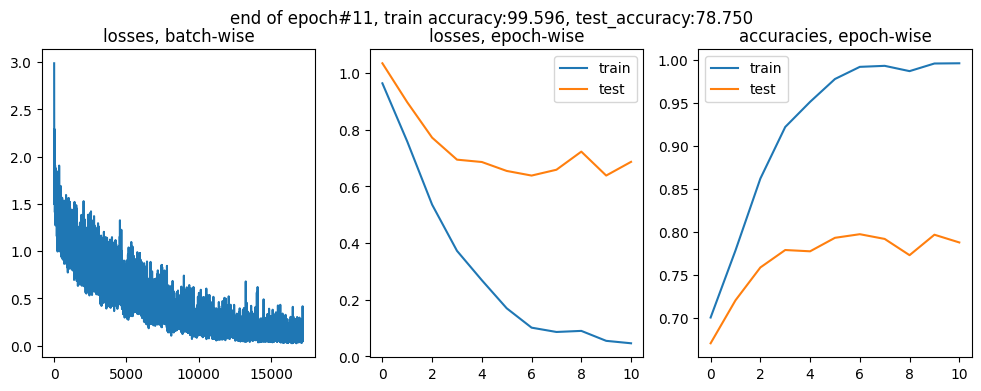

100%|██████████| 313/313 [00:02<00:00, 144.09it/s]


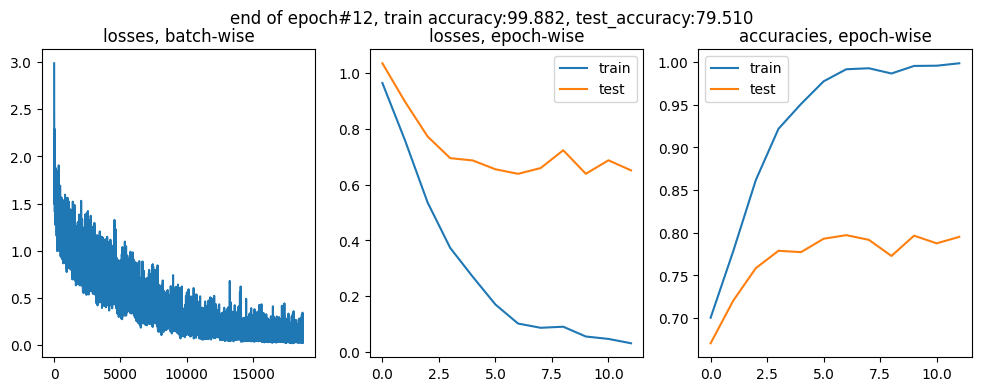

100%|██████████| 313/313 [00:02<00:00, 145.29it/s]


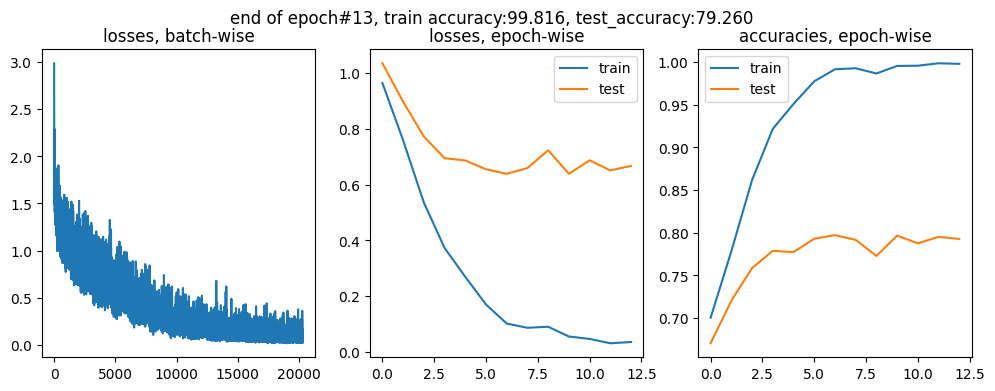

100%|██████████| 313/313 [00:02<00:00, 147.41it/s]


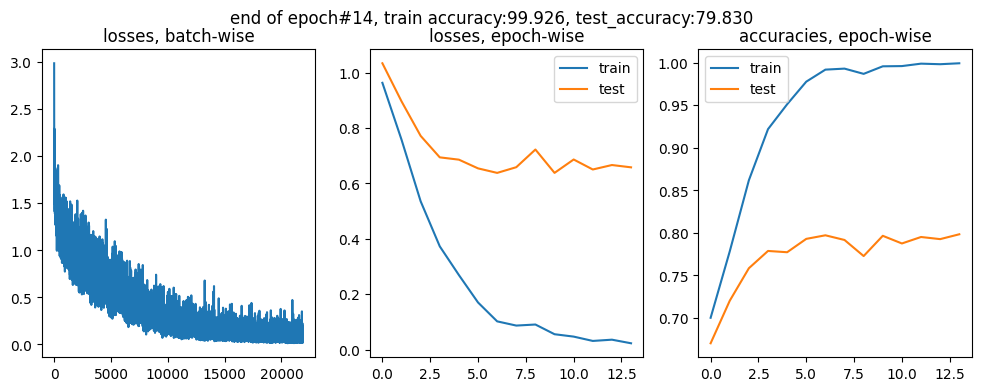

100%|██████████| 313/313 [00:02<00:00, 148.71it/s]


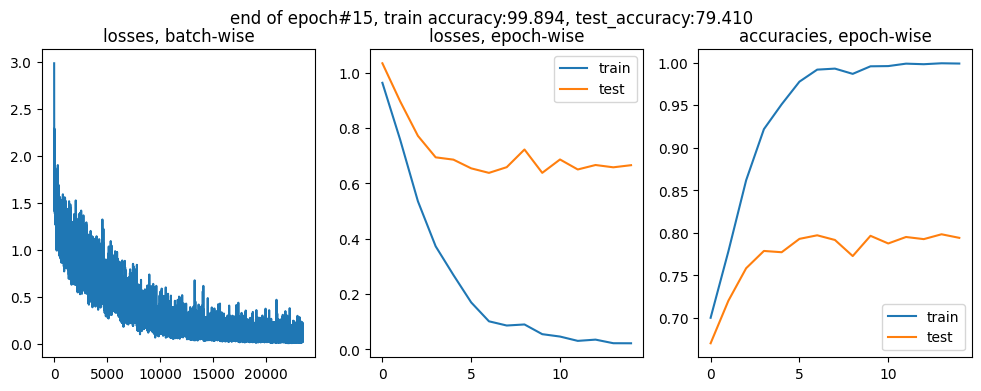

100%|██████████| 313/313 [00:02<00:00, 148.67it/s]


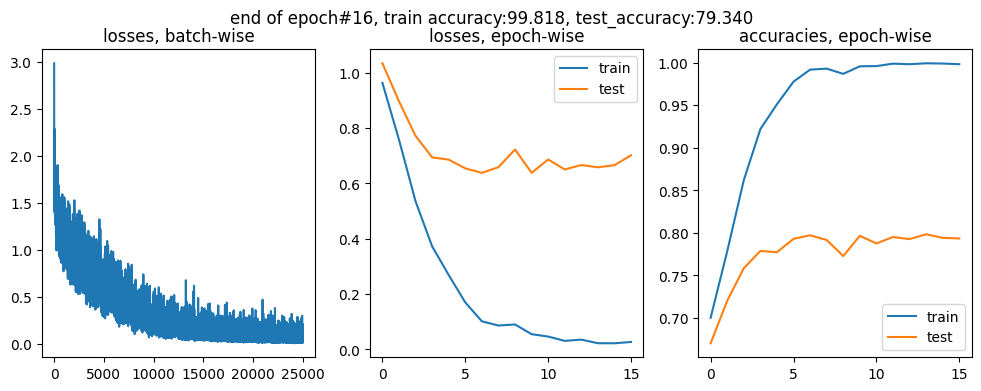

100%|██████████| 313/313 [00:02<00:00, 136.64it/s]


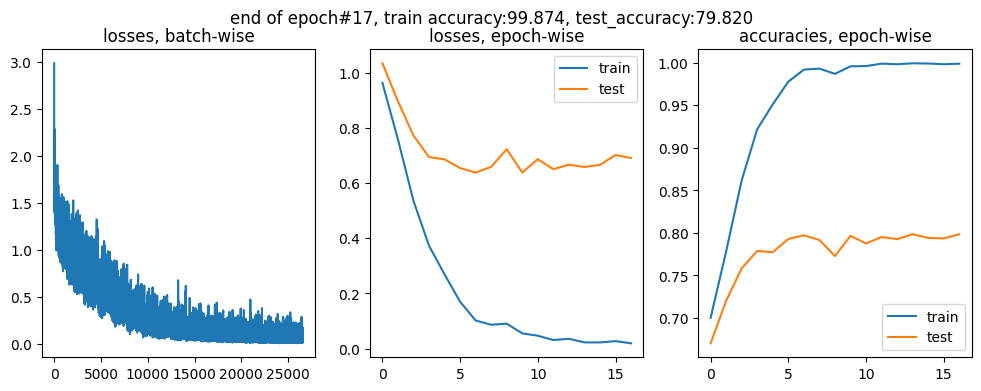

100%|██████████| 313/313 [00:02<00:00, 135.64it/s]


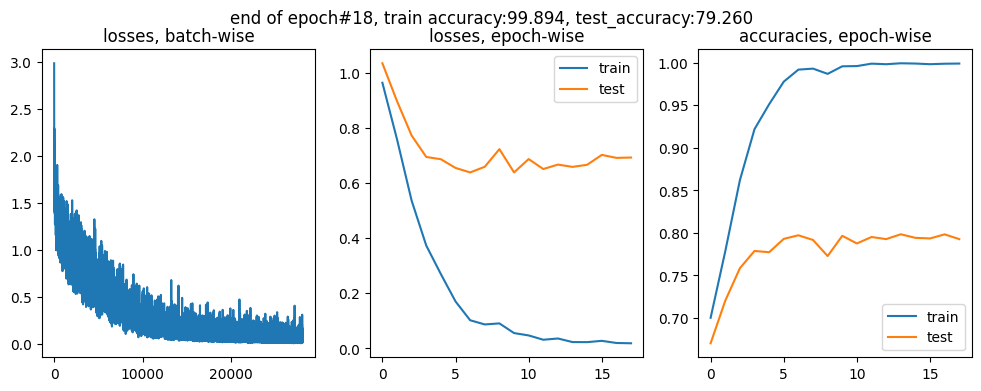

100%|██████████| 313/313 [00:02<00:00, 145.50it/s]


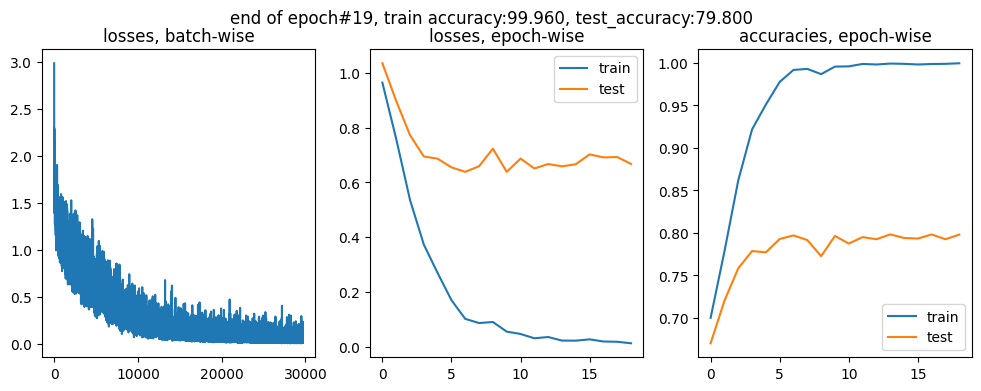

100%|██████████| 313/313 [00:02<00:00, 146.80it/s]


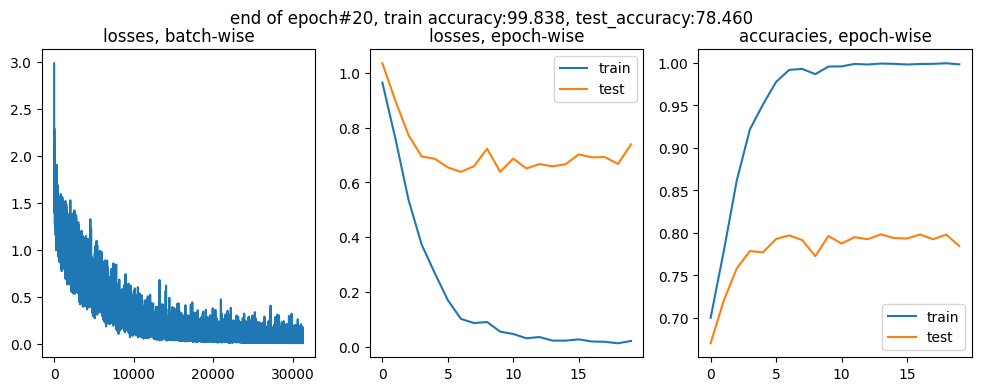

In [ ]:
model.to(device)
model.train()

# train_losses.append(get_loss(model, train_loader, criterion))
# test_losses.append(get_loss(model, test_loader, criterion))
# train_accuracies.append(get_accuracy(model, train_loader))
# test_accuracies.append(get_accuracy(model, test_loader))
for epoch in range(num_epochs):

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        scores = model(images)
        loss = criterion(scores, labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    train_losses.append(get_loss(model, train_loader, criterion))
    test_losses.append(get_loss(model, test_loader, criterion))
    train_accuracies.append(get_accuracy(model, train_loader))
    test_accuracies.append(get_accuracy(model, test_loader))
    show_stats(losses, train_losses, test_losses, train_accuracies, test_accuracies, epoch)
    state_dicts.append(deepcopy(model.state_dict()))




In [ ]:
for epoch, test_accuracy, state_dict in list(zip(range(len(state_dicts)), test_accuracies, state_dicts)):
    MODEL_SAVE_PATH = f'saved/cnn/epoch{epoch+1}_acc{test_accuracy}.pt'
    torch.save(state_dict, MODEL_SAVE_PATH)

## Load best CNN model


In [ ]:
# load cnn model - autoaugment
model = CNN(**cnn_kwargs).to(device)
model.load_state_dict(torch.load(r'saved\cnn_autoaugment\epoch19_acc0.8378.pt'))
bn_compute(model, train_loader)
print(f'accuracy of model on test: {get_accuracy(model, test_loader)}')

100%|██████████| 313/313 [00:01<00:00, 168.39it/s]

accuracy of model on test: 0.8431


## FGSM attack


In [ ]:
# FGSM attack code
def fgsm_attack(model, images, labels, criterion, epsilon):
    images.requires_grad = True
    scores = model(images)
    loss = criterion(scores, labels)
    model.zero_grad()
    loss.backward()
    images_grad = images.grad.data

    images_grad_sign = images_grad.sign()
    perturbed_images = images + epsilon * images_grad_sign
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
    return perturbed_images


def get_accuracy_fgsm(model, loader, criterion, epsilon, count=-1):
    # model.eval()
    correct, total = 0, 0
    model.eval()
    for images, labels in tqdm(loader):
        if count == 0: break
        else: count -=1
        images, labels = images.to(device), labels.to(device)

        # Attacking the images with FGSM
        perturbed_images = fgsm_attack(model, images, labels, criterion, epsilon)
        perturbed_scores = model(perturbed_images)
        preds = perturbed_scores.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += (labels == labels).sum().item()
    model.train()
    return float(correct / total)

def plot_attacked_images_fgsm(model, loader, criterion, epsilon, count=-1):
    model.eval()
    for images, labels in loader:
        break
    images, labels = images.to(device), labels.to(device)
    perturbed_images = fgsm_attack(model, images, labels, criterion, epsilon)
    perturbed_scores = model(perturbed_images)
    preds = perturbed_scores.argmax(dim=1)

    fig, axs = plt.subplots(nrows=1, ncols=10, figsize=[2.5*9, 2.5])
    fig.suptitle(f'FGSM attack, epsilon={epsilon}')
    for i, (image, label, pred) in enumerate(list(zip(images, labels, preds))):
        axs[i].imshow(transforms.ToPILImage()(image))
        if int(label) == int(pred):
            axs[i].set_xlabel(f'actual={idx_to_class[int(label)]}\npred={idx_to_class[int(pred)]}')
        else:
            axs[i].set_xlabel(f'actual={idx_to_class[int(label)]}\npred={idx_to_class[int(pred)]}\nATTACK SUCCESS')

        if i == 9: break
    plt.show()


epsilons = [0, 0.0001, 0.001, 0.01, 0.1, 1]
fgsm_accuracies = [get_accuracy_fgsm(model, test_loader, criterion, epsilon=epsilon) for epsilon in epsilons]

100%|██████████| 313/313 [00:04<00:00, 77.85it/s]


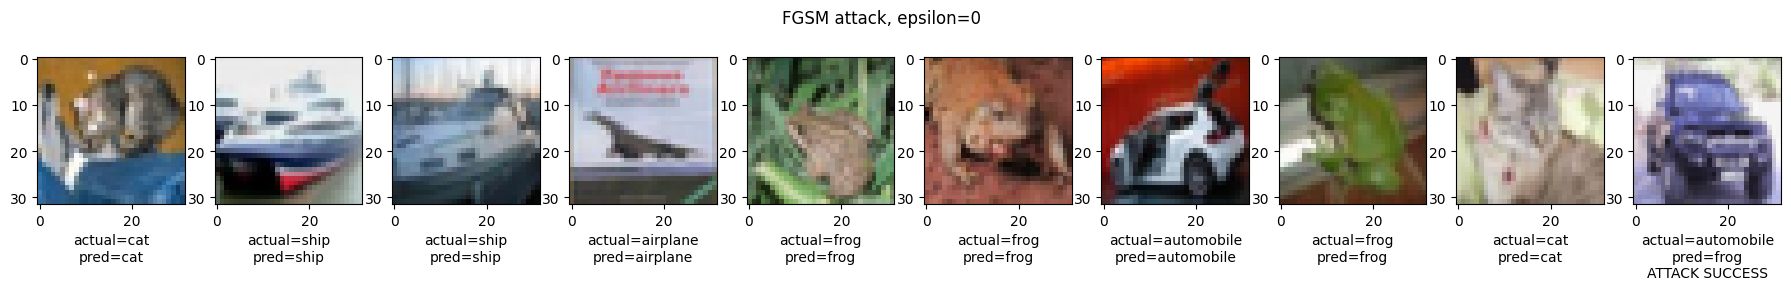

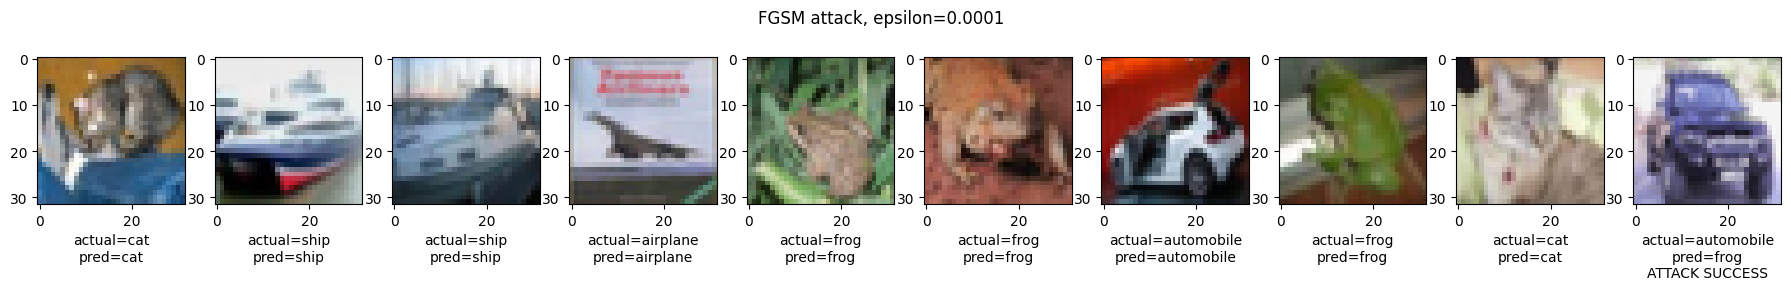

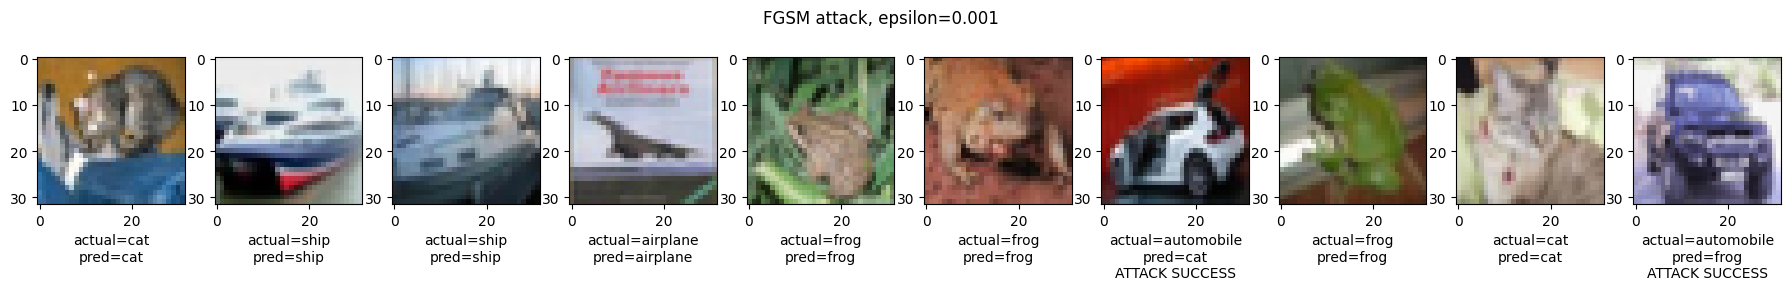

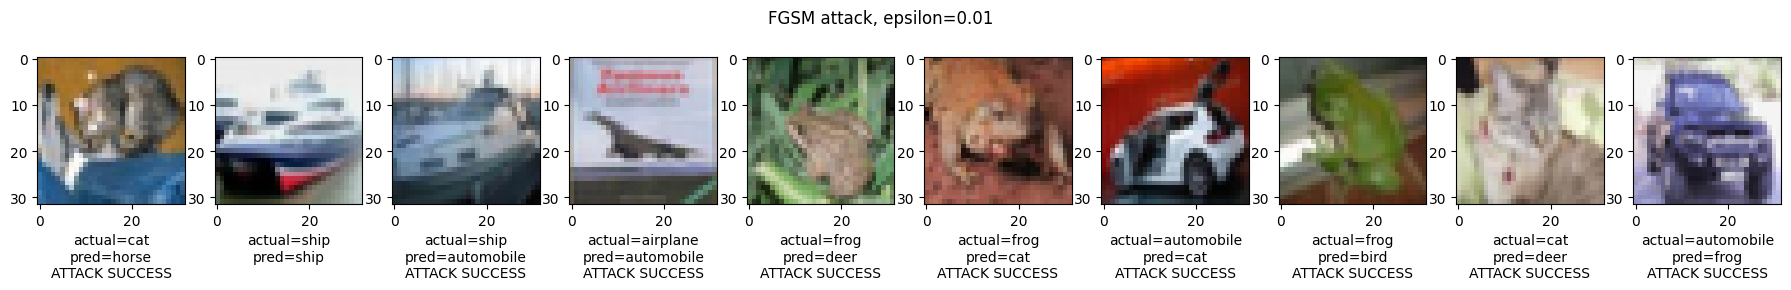

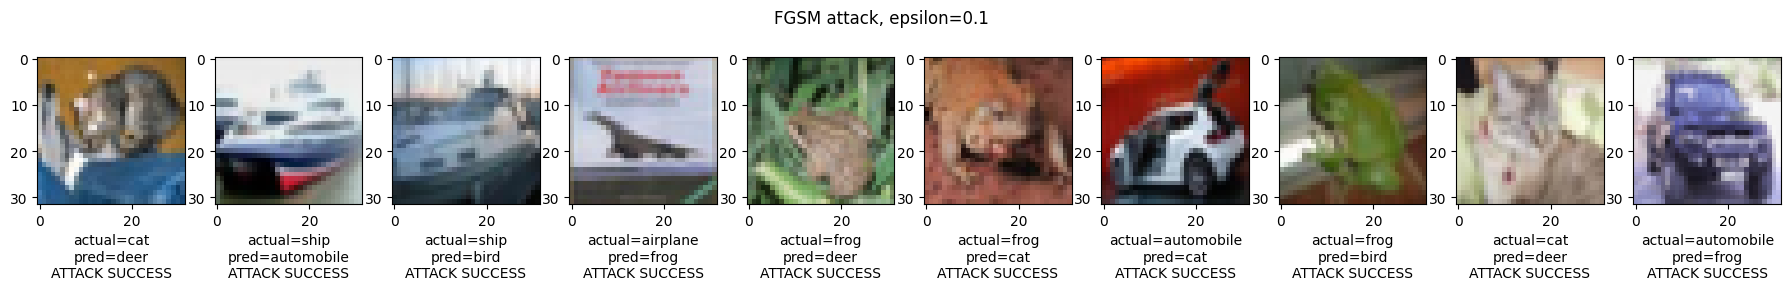

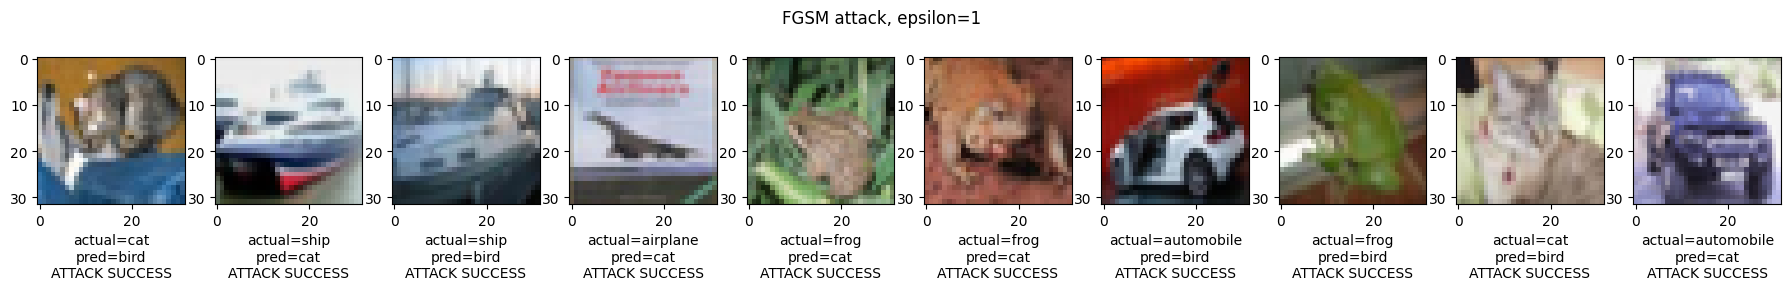

In [ ]:
for epsilon in epsilons:
    plot_attacked_images_fgsm(model, test_loader, criterion, epsilon=epsilon)

In [ ]:
for epsilon, fgsm_accuracy in zip(epsilons, fgsm_accuracies):
    print(f'for epsilon={epsilon:< 13} after fgsm attack, test accuracy on attacked images: {fgsm_accuracy*100:> 6.2f} %')

for epsilon= 0            after fgsm attack, test accuracy on attacked images:  84.31 %
for epsilon= 0.0001       after fgsm attack, test accuracy on attacked images:  83.72 %
for epsilon= 0.001        after fgsm attack, test accuracy on attacked images:  78.11 %
for epsilon= 0.01         after fgsm attack, test accuracy on attacked images:  26.00 %
for epsilon= 0.1          after fgsm attack, test accuracy on attacked images:   0.54 %
for epsilon= 1            after fgsm attack, test accuracy on attacked images:   7.69 %


# Part 2 - 2 new models, 2 more attacks on SVHN
There are a plethora of deep-learning architectures available for classifying images. The current standard in deep learning is to take models pre-trained on larger, more challenging datasets and to use transfer learning i.e. fine-tune those representations on a new dataset, which in this case is CIFAR-10. Thus, I choose two architectures pre-trained on ImageNet dataset for the analysis in this question - 

1. ResNet34
2. VGG11

The dataset used in this part will be SVHN.

## loading SVHN dataset

In [ ]:
num_classes = 10
C, H, W = [3, 224, 224]
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([224, 224]),
])
train_dataset = datasets.SVHN('datasets', split='train', transform=tfms, download=True)
test_dataset = datasets.SVHN('datasets', split='test', transform=tfms, download=True)
class_to_idx = {key:value for key, value in enumerate(range(10))}
idx_to_class = {value:key for key, value in enumerate(range(10))}

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

## Plotting some images from SVHN, 

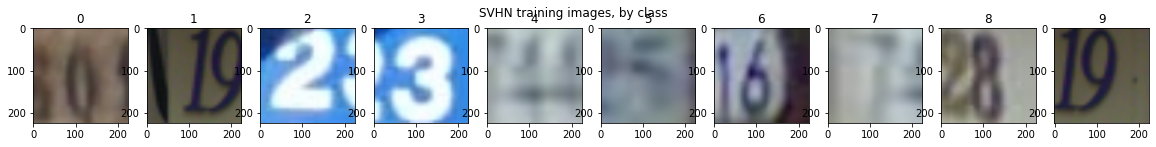

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=num_classes, figsize=[2*num_classes, 2])
fig.suptitle(f'SVHN training images, by class')
for class_idx in range(num_classes):
    axs[class_idx].set_title(idx_to_class[class_idx])
    for image, label in train_dataset:
        if label == class_idx:
            axs[class_idx].imshow(transforms.ToPILImage()(image))
            break
plt.show()

In [ ]:
def load_vgg11(num_classes):
    m = torchvision.models.vgg11_bn(weights='IMAGENET1K_V1')
    m.classifier = nn.Sequential(
      nn.Linear(512 * 7 * 7, 512),
      nn.BatchNorm1d(512),
      nn.ReLU(True),
      nn.Linear(512, num_classes),
    )
    return m

def load_resnet34(num_classes):
    m = torchvision.models.resnet34(weights='IMAGENET1K_V1')
    m.fc = nn.Linear(512, num_classes)
    return m


batch_size = 16
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ResNet34

### Load ResNet34

In [ ]:
model = load_resnet34(num_classes).to(device)
summary(model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
!unzip -d saved drive/MyDrive/saved.rar

unzip:  cannot find or open drive/MyDrive/saved.rar, drive/MyDrive/saved.rar.zip or drive/MyDrive/saved.rar.ZIP.


### Train ResNet34

In [ ]:
num_epochs = 5
learning_rate = 3e-4
criterion = nn.CrossEntropyLoss()
tfm_resnet = transforms.Compose(
    [
    ]
)

optimizer = torch.optim.Adam(
    [
        {'params':model.conv1.parameters() , 'lr':3e-8},
        {'params':model.bn1.parameters()   , 'lr':3e-8},
        {'params':model.layer1.parameters(), 'lr':1e-6},
        {'params':model.layer2.parameters(), 'lr':1e-6},
        {'params':model.layer3.parameters(), 'lr':1e-6},
        {'params':model.layer4.parameters(), 'lr':1e-6},
        {'params':model.fc.parameters()    , 'lr':1e-4},
    ],
)

In [ ]:
losses = []
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
state_dicts = []

In [ ]:
model.to(device)
model.train()

for epoch in range(num_epochs):
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        images = tfm_resnet(images)

        scores = model(images)
        optimizer.zero_grad()
        loss = criterion(scores, labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    train_losses.append(get_loss(model, train_loader, criterion))
    test_losses.append(get_loss(model, test_loader, criterion))
    train_accuracies.append(get_accuracy(model, train_loader))
    test_accuracies.append(get_accuracy(model, test_loader))
    show_stats(losses, train_losses, test_losses, train_accuracies, test_accuracies, epoch)
    state_dicts.append(deepcopy(model.state_dict()))



  8%|▊         | 365/4579 [00:33<06:26, 10.90it/s]


KeyboardInterrupt: ignored

### Load trained ResNet34 model

In [ ]:
model = load_resnet34(num_classes).to(device)
model.load_state_dict(torch.load(r'saved\resnet34\epoch7_acc0.9679625076828519.pt'))
get_accuracy(model, test_loader, count=500)

## VGG11

### Load VGG11

In [ ]:
model = load_vgg11(num_classes).to(device)
summary(model, (3, 224, 224))

### Train VGG11

In [ ]:
num_epochs = 8
weight_decay = 0
criterion = nn.CrossEntropyLoss()
tfm_vgg = transforms.Compose(
    [
    ]
)

autoaugment = transforms.AutoAugment(policy=torchvision.transforms.autoaugment.AutoAugmentPolicy.CIFAR10)
float_to_uint8 = transforms.Lambda(lambda img_float: (img_float * 255).clamp(0, 255).to(torch.uint8))
uint8_to_float = transforms.Lambda(lambda img_uint8: img_uint8.to(torch.float32) / 255)

def lambda1(epoch):
  if epoch < 3:
    return 1e0
  elif epoch < 6:
    return 1e-1
  elif epoch < 8:
    return 1e-2
  else:
    return 1e-3
optimizer = torch.optim.Adam(
    [
        {'params':model.features.parameters()  , 'initial_lr':1e-5},
        {'params':model.classifier.parameters()  , 'initial_lr':1e-3},
    ],
    weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, 
                        lr_lambda=[lambda1, lambda1])

In [ ]:
losses = []
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
state_dicts = []

In [ ]:
model.to(device)
model.train()

for epoch in range(num_epochs):
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        images = tfm_vgg(images)
        scores = model(images)
        optimizer.zero_grad()
        loss = criterion(scores, labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    scheduler.step()
    train_losses.append(get_loss(model, train_loader, criterion))
    test_losses.append(get_loss(model, test_loader, criterion))
    train_accuracies.append(get_accuracy(model, train_loader))
    test_accuracies.append(get_accuracy(model, test_loader))
    show_stats(losses, train_losses, test_losses, train_accuracies, test_accuracies, epoch)
    state_dicts.append(deepcopy(model.state_dict()))



for images, labels in train_loader:
  model.train()
  images, labels = images.to(device), labels.to(device)
  print(sum(model(images).argmax(dim=1) == labels), labels.shape[0])
  break

In [ ]:
for epoch, test_accuracy, state_dict in list(zip(range(len(state_dicts)), test_accuracies, state_dicts)):
    MODEL_SAVE_PATH = f'saved/vgg11_bn/epoch{epoch+1}_acc{test_accuracy}.pt'
    torch.save(state_dict, MODEL_SAVE_PATH)

### Load trained VGG11 model

In [ ]:
model = load_vgg11(num_classes).to(device)
model.load_state_dict(torch.load(r'saved\vgg11_bn\epoch1_acc0.9574370006146281.pt'))
get_accuracy(model, test_loader, count=500)

## Attacking trained models
I decided to demonstrate attacks on the 2 newly trained classifiers using the following attacks:
1. PGD
2. Single Pixel Attack

In [ ]:
import foolbox as fb

In [ ]:
# model1 = load_vgg11(num_classes).to(device)
# model1.load_state_dict(torch.load(r'drive/MyDrive/saved/vgg11_bn/epoch9_acc0.9620467117393977.pt'))
# model2 = load_resnet34(num_classes).to(device)
# model2.load_state_dict(torch.load(r'drive/MyDrive/saved/resnet34/epoch7_acc0.9679625076828519.pt'))

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
def eval_attacks(fmodel, model, loader, model_name, count=100):
    torch.cuda.empty_cache()
    model.eval()
    attack_functions = [
        None,
        fb.attacks.LinfPGD(),
        fb.attacks.LinfDeepFoolAttack(),
    ]
    attack_names = [
        'benign images',
        'pgd',
        'deepfool',
    ]
    attack_kwargs = [
        {},
        {
            'epsilons':[0.003],
        },
        {
            'epsilons':[0.003],
        }
    ]
    attack_accuracies = [

    ]

    for attack_function, attack_name, attack_id, attack_kwarg in zip(attack_functions, attack_names, range(len(attack_names)), attack_kwargs):
        correct = 0
        total = 0
        counter = count
        for images, labels in tqdm(loader):
            if counter == 0: break
            counter -= 1
            images, labels = images.to(device), labels.to(device)
            if attack_function is not None:
              attacked_images = attack_function(fmodel, images, labels, **attack_kwarg)[1][0]
            else:
              attacked_images = images
            scores = model(attacked_images)
            preds = scores.argmax(dim=1)
            correct += int(sum(preds == labels))
            total += int(labels.shape[0])
        print(correct, total)
        accuracy = 100 * (correct / total)
        attack_accuracies.append(accuracy)
    plt.figure(figsize=[10, 10])
    plt.bar(attack_names, attack_accuracies)
    plt.title(f'{model_name} accuracy over different attacks')
    plt.ylim([0, 100])
    plt.show()

In [ ]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    4556 MB |    7178 MB |  122977 GB |  122972 GB |
|       from large pool |    4542 MB |    7170 MB |  122854 GB |  122850 GB |
|       from small pool |      14 MB |      25 MB |     122 GB |     122 GB |
|---------------------------------------------------------------------------|
| Active memory         |    4556 MB |    7178 MB |  122977 GB |  122972 GB |
|       from large pool |    4542 MB |    7170 MB |  122854 GB |

In [ ]:
model1 = load_vgg11(num_classes).to(device)
model1.eval()
model1.load_state_dict(torch.load(f'drive/MyDrive/saved/vgg11_bn/epoch9_acc0.9620467117393977.pt'))
fmodel1 = fb.PyTorchModel(model1, bounds=(0, 1))

In [ ]:
model2 = load_resnet34(num_classes).to(device)
model2.eval()
model2.load_state_dict(torch.load(f'drive/MyDrive/saved/resnet34/epoch7_acc0.9679625076828519.pt'))
fmodel2 = fb.PyTorchModel(model2, bounds=(0, 1))

  6%|▌         | 100/1627 [00:05<01:27, 17.37it/s]


1540 1600


  6%|▌         | 100/1627 [08:02<2:02:49,  4.83s/it]


472 1600


  6%|▌         | 100/1627 [10:44<2:43:53,  6.44s/it]

731 1600


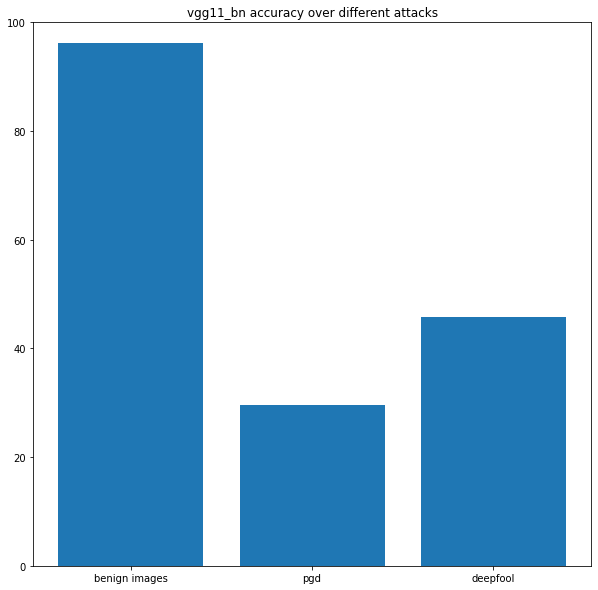

In [ ]:
eval_attacks(fmodel1, model1, test_loader, 'vgg11_bn')

  6%|▌         | 100/1627 [00:03<00:58, 26.18it/s]


1547 1600


  6%|▌         | 100/1627 [05:24<1:22:33,  3.24s/it]


468 1600


  6%|▌         | 100/1627 [07:38<1:56:39,  4.58s/it]


613 1600


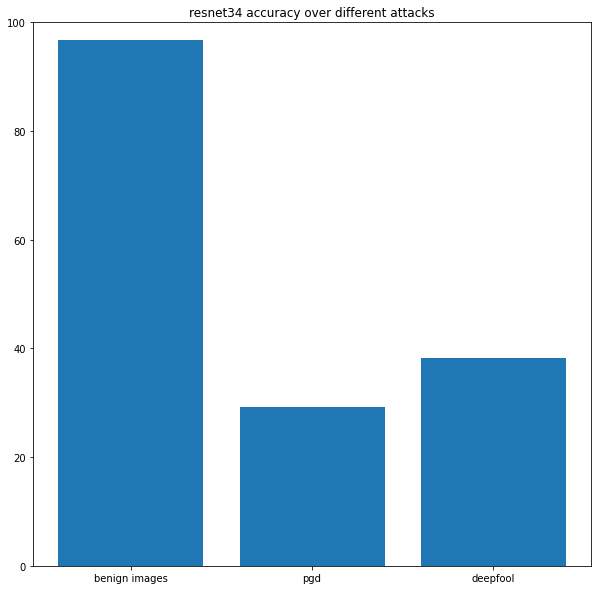

In [ ]:
eval_attacks(fmodel2, model2, test_loader, 'resnet34')

## Detecting the adversarial attacks

### Loading CIFAR-10

In [ ]:
C, H, W = [3, 32, 32]
num_classes = 10

tfms = transforms.Compose(
    [
        transforms.Resize([H, W]),
        transforms.ToTensor(),
    ]
)
batch_size = 16
train_dataset = datasets.CIFAR10(root='datasets', train=True, transform=tfms, target_transform=None, download=True)
test_dataset = datasets.CIFAR10(root='datasets', train=False, transform=tfms, target_transform=None, download=True)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

idx_to_class = { value:key for key, value in train_dataset.class_to_idx.items() } # for getting the class name from class indices when needed
class_to_idx = { key:value for key, value in train_dataset.class_to_idx.items() } # for getting the class indices from class names when needed

Files already downloaded and verified
Files already downloaded and verified


### Victim model

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes, input_channels):
        super(CNN, self).__init__()
        conv_layers = [64, 128, 256]
        self.layers = nn.ModuleList([
            nn.Conv2d(input_channels, conv_layers[0], kernel_size=3, padding=1, stride=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(conv_layers[0], conv_layers[1], kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(conv_layers[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(conv_layers[1], conv_layers[2], kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(conv_layers[2]),
            nn.ReLU(),
            nn.Flatten(),
        ])
        self.fc = nn.ModuleList([
            nn.Linear(8 * 8 * 256, 1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes, bias=False),
            nn.BatchNorm1d(num_classes),
        ])
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        for layer in self.fc:
            x = layer(x)
        return x

cnn_kwargs = {
    'num_classes': num_classes,
    'input_channels': C,
}

In [ ]:
# load cnn model - autoaugment
model = CNN(**cnn_kwargs).to(device)
model.load_state_dict(torch.load('saved/cnn_autoaugment/epoch19_acc0.8378.pt'))
bn_compute(model, train_loader)
print(f'accuracy of model on test: {get_accuracy(model, test_loader)}')

100%|██████████| 625/625 [00:02<00:00, 262.60it/s]

accuracy of model on test: 0.8408


### Discriminator model

In [ ]:
discrim_kwargs = {
    'num_classes': 2,
    'input_channels': C,
}

discriminator = CNN(**discrim_kwargs).to(device)
summary(discriminator, (C, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,728
       BatchNorm2d-5          [-1, 128, 16, 16]             256
              ReLU-6          [-1, 128, 16, 16]               0
         MaxPool2d-7            [-1, 128, 8, 8]               0
            Conv2d-8            [-1, 256, 8, 8]         294,912
       BatchNorm2d-9            [-1, 256, 8, 8]             512
             ReLU-10            [-1, 256, 8, 8]               0
          Flatten-11                [-1, 16384]               0
           Linear-12                 [-1, 1024]      16,777,216
      BatchNorm1d-13                 [-1, 1024]           2,048
             ReLU-14                 [-

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate=1e-3
optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
limit = batch_size//2

In [ ]:
losses = []

In [ ]:
# FGSM attack code
def fgsm_attack(model, images, labels, criterion, epsilon):
    images.requires_grad = True
    scores = model(images)
    loss = criterion(scores, labels)
    model.zero_grad()
    loss.backward()
    images_grad = images.grad.data

    images_grad_sign = images_grad.sign()
    perturbed_images = images + epsilon * images_grad_sign
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
    return perturbed_images

def taint_batch(model, images, labels, criterion):
    benign_images, benign_labels = images[:limit], labels[:limit]
    pertur_images, pertur_labels = images[limit:], labels[limit:]
    pertur_images = fgsm_attack(model, pertur_images, pertur_labels, criterion, epsilon=0.01)
    benign_labels = benign_labels * 0
    pertur_labels = pertur_labels * 0 + 1
    images, labels = torch.cat([benign_images, pertur_images], dim=0), torch.cat([benign_labels, pertur_labels], dim=0)
    return images, labels

100%|██████████| 3125/3125 [01:01<00:00, 50.82it/s]


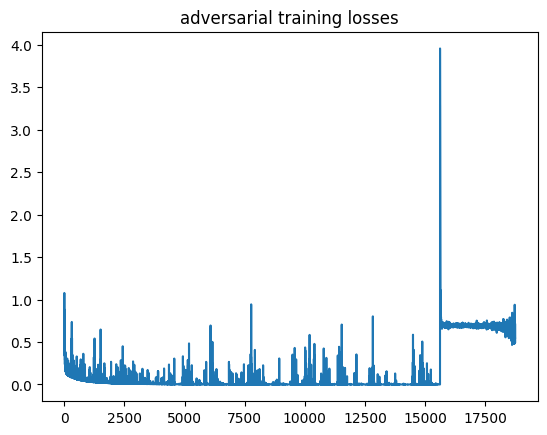

100%|██████████| 3125/3125 [01:01<00:00, 50.97it/s]


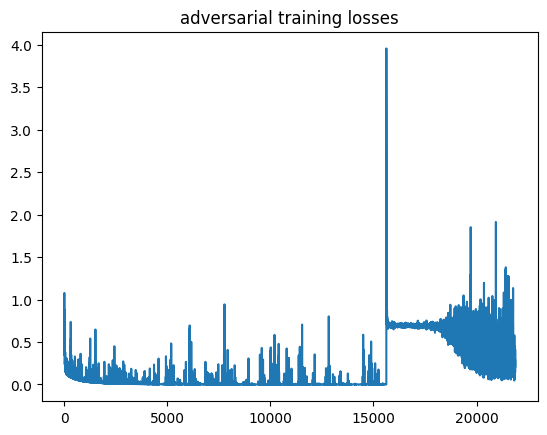

100%|██████████| 3125/3125 [01:01<00:00, 50.92it/s]


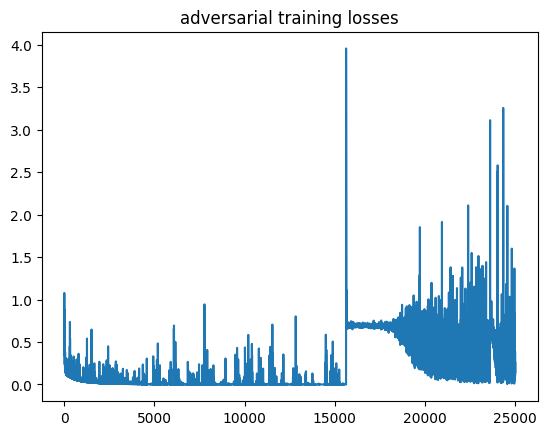

100%|██████████| 3125/3125 [01:01<00:00, 50.78it/s]


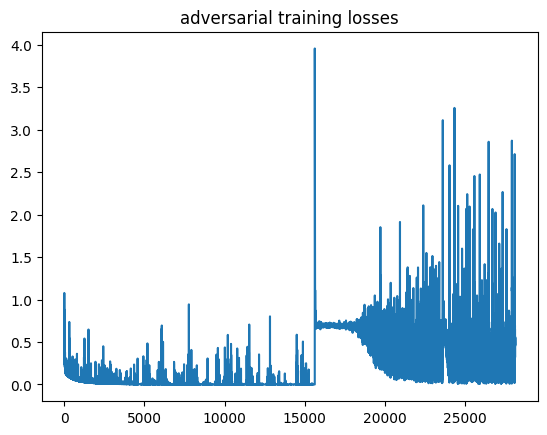

100%|██████████| 3125/3125 [01:01<00:00, 51.22it/s]


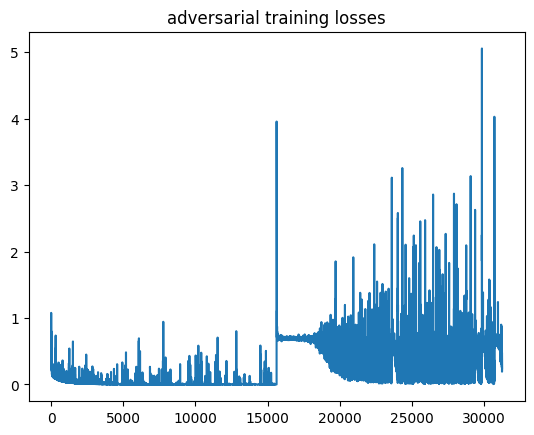

In [ ]:
for epoch in range(5):
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        images, labels = taint_batch(model, images, labels, criterion)
        loss = criterion(discriminator(images), labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    plt.plot(losses)
    plt.title('adversarial training losses')
    plt.show()

In [ ]:
def detection_accuracy(model, discriminator, loader, criterion):
    model.eval()
    discriminator.eval()
    correct = 0
    total = 0
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)
        images, labels = taint_batch(model, images, labels, criterion)
        preds = discriminator(images).argmax(dim=1)
        correct += int(sum(preds == labels))
        total += int(sum(labels == labels))
    model.train()
    return correct / total        

In [ ]:
train_detection_accuracy = detection_accuracy(model, discriminator, train_loader, criterion)
test_detection_accuracy = detection_accuracy(model, discriminator, test_loader, criterion)

100%|██████████| 625/625 [00:05<00:00, 108.11it/s]


In [ ]:
train_detection_accuracy, test_detection_accuracy

(0.89374, 0.8895)

# Question 2 - fine tuning the model onto deepfakes

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([H, W]),
])
dataset = ImageFolder('deepfakes', transform=tfms)

train_len = int(len(dataset) * 0.5)
test_len  = len(dataset) - train_len

train_dataset, test_dataset = random_split(dataset, [train_len, test_len])
train_loader, test_loader = [DataLoader(dset, batch_size=51, shuffle=True) for dset in [train_dataset, test_dataset]]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
losses = []

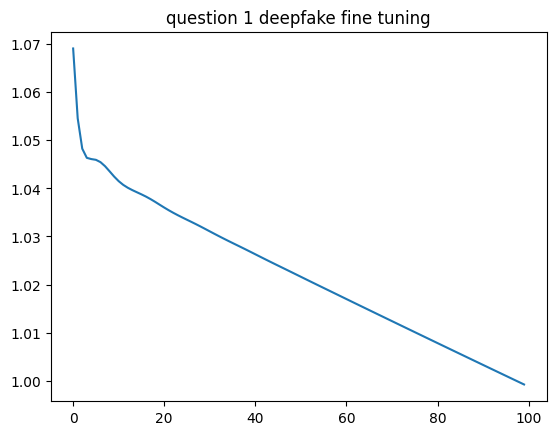

In [ ]:
for epoch in range(100):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        scores = model(images)
        loss = criterion(scores, labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
plt.plot(losses)
plt.title('question 1 deepfake fine tuning')
plt.show()

In [ ]:
train_acc = get_accuracy(model, train_loader)
test_acc = get_accuracy(model, test_loader)
print(train_acc, test_acc)

100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

1.0 0.9803921568627451
